In [9]:
from embedding.parser import Parser, Rule
from embedding.schema import Schema
from embedding.encoder import Encoder
from embedding.array import array_to_tree
from embedding.structure import Struct
import numpy as np
import matplotlib.pyplot as plt



def random_parse_tree(depth):
    rule_num = np.random.choice([0,1,2])
    
    if depth == 1 or rule_num == 0:
        return 'E', {'arg1': 'L', 'arg2': 'R'}

    if rule_num == 1:
        return 'E', {
            'arg1': 'L', 
            'arg2': random_parse_tree(depth - 1), 
            'arg3': 'R'}
    
    if rule_num == 2:
        return 'E', {
            'arg1': random_parse_tree(depth - 1), 
            'arg2': random_parse_tree(depth - 1) }
    
def deparse(st):
    if isinstance(st, Struct):
        st = st.to_array()
    res = []
    lab = st[0]
    attr = st[1] if len(st) == 2 else {}
    if lab == 'E':
        res += deparse(attr['arg1'])
        res += deparse(attr['arg2'])
        if len(attr) == 3:
            res += deparse(attr['arg3'])
    else:
        res.append(lab)
        
    return res


def validate(st):
    if isinstance(st, Struct):
        st = st.to_array()
    
    try:    
        if st[0] in ['L', 'R']:
            return True
        if st[0] == 'E' and len(st[1]) == 2:
            a1 = st[1]['arg1']
            a2 = st[1]['arg2']
            if a1 == 'L' and a2 == 'R':
                return True
            if a1[0] == 'E' and a2[0] == 'E':
                return validate(a1) and validate(a2)
            return False
        if st[0] == 'E' and len(st[1]) == 3:
            a1 = st[1]['arg1']
            a2 = st[1]['arg2']
            a3 = st[1]['arg3']
            if a1 == 'L' and a2[0] == 'E' and a3 == 'R':
                return validate(a2)
            return False
        return False
    except KeyError:
        return False

In [2]:
validate(random_parse_tree(4))

True

In [7]:

def test_parse(seq, exp, enc, sc):
    seq_vec = [x for x in map(enc, seq)]

    y = p.parse(seq_vec)
    
    exp = Struct.create(sc, exp)
    tr = en.decode(y[0])
    if tr is None:
        return False
    tr = tr.to_strings()
    
    return validate(tr) and deparse(tr) == seq


def add_trees(trees, n, depth, lim, max=10):
    ln0 = len(trees)
    i = 0
    while len(trees) < ln0 + n:
        while True and i < max*n:
            tree = random_parse_tree(depth)
            if len(deparse(tree)) <= lim:
                trees[str(tree)] = tree
                break    
            i += 1

In [18]:
def get_trees(n):
    trees = dict()


    add_trees(trees, n, 5, 20)
    add_trees(trees, n, 6, 30)
    #add_trees(100, 6, 12)
    #add_trees(100, 7, 14)
    #add_trees(100, 8, 16)
    
    return trees

In [28]:
random_parse_tree(4)

('E', {'arg1': 'L', 'arg2': ('E', {'arg1': 'L', 'arg2': 'R'}), 'arg3': 'R'})

(array([ 1.,  0.,  2.,  0.,  0.,  6.,  0., 20.,  0., 21.]),
 array([ 2. ,  2.8,  3.6,  4.4,  5.2,  6. ,  6.8,  7.6,  8.4,  9.2, 10. ]),
 <BarContainer object of 10 artists>)

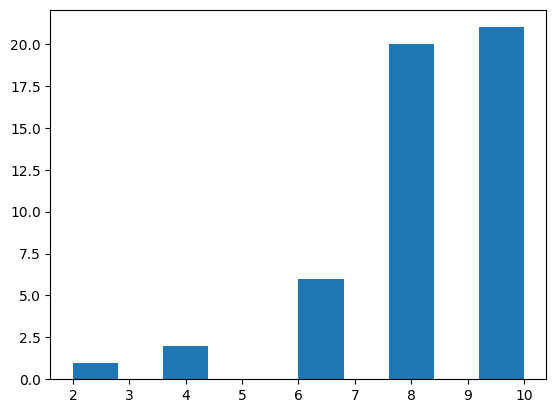

In [5]:
t = get_trees(50)
x= [len(deparse(t)) for t in t.values()]
plt.hist(x)

In [ ]:
good = 0
bad = 0
res = []

dims = [x for x in range(2000,100,-50)]
trees = get_trees(50)
#trees = {k: v for k, v in trees.items() if len(deparse(v)) == 8}

for dim in dims:
    sc = Schema(labels=['L', 'R', 'E'],
                attributes=['next', 'arg1', 'arg2', 'arg3'])

    en = Encoder(schema=sc, dim=dim, seed=42)
    def enc(a):
        return en.encode(array_to_tree(a))

    e = enc(['E'])

    r1 = Rule(length=2,
              pattern=enc(['L', 'R']),
              replacement=e)

    r2 = Rule(length=3,
             pattern=enc(['L', 'E', 'R']),
              replacement=e)

    r3 = Rule(length=2,
              pattern=enc(['E', 'E']),
              replacement=e)

    p = Parser(schema=sc,
               rules=[r1, r2, r3],
               next_a=en.attr_emb[sc.attr_to_ind['next']],
               args=[en.attr_emb[sc.attr_to_ind[x]] for x in ['arg1', 'arg2', 'arg3']])

    for t in trees.values():
        ld = len(deparse(t))
        ret = test_parse(deparse(t), t, enc, sc)
    
        if ret:
            good += 1
        else:
            bad += 1
        
        res.append((dim, ld, ret))
        print(dim, ld, good, bad)

2000 4 1 0
2000 16 2 0
2000 2 3 0
2000 14 4 0
2000 20 4 1
2000 4 5 1
2000 14 6 1
2000 10 7 1
2000 12 8 1
2000 8 9 1
2000 12 10 1
2000 20 11 1
2000 8 12 1
2000 12 13 1
2000 10 14 1
2000 8 15 1
2000 12 16 1
2000 14 17 1
2000 6 18 1
2000 14 19 1
2000 10 20 1
2000 16 21 1
2000 10 22 1
2000 6 23 1
2000 12 24 1
2000 12 25 1
2000 8 26 1
2000 18 27 1
2000 10 28 1
2000 8 29 1
2000 12 30 1
2000 6 31 1
2000 10 32 1
2000 14 33 1
2000 10 34 1
2000 12 35 1
2000 10 36 1
2000 12 37 1
2000 14 38 1
2000 10 39 1
2000 6 40 1
2000 8 41 1
2000 10 42 1
2000 8 43 1
2000 10 44 1
2000 14 45 1
2000 14 46 1
2000 12 47 1
2000 10 48 1
2000 10 49 1
2000 16 50 1
2000 12 51 1
2000 18 52 1
2000 14 53 1
2000 20 54 1
2000 16 55 1
2000 12 56 1
2000 14 57 1
2000 6 58 1
2000 30 58 2
2000 12 58 3
2000 22 58 4
2000 14 59 4
2000 14 60 4
2000 8 61 4
2000 8 62 4
2000 18 63 4
2000 6 64 4
2000 14 65 4
2000 22 66 4
2000 24 66 5
2000 16 67 5
2000 18 68 5
2000 16 69 5
2000 24 70 5
2000 14 71 5
2000 16 72 5
2000 22 73 5
2000 14 74 5
2

In [15]:
rr = np.array(res)

In [16]:
agg = []
keys = {(r[0], r[1]) for r in rr}
for d, l in keys:
    agg.append((d, l, np.mean(rr[(rr[:,0]==d) & (rr[:,1]==l),2])))
agg = np.array(agg)
agg = agg[agg[:,1] < 20,:]

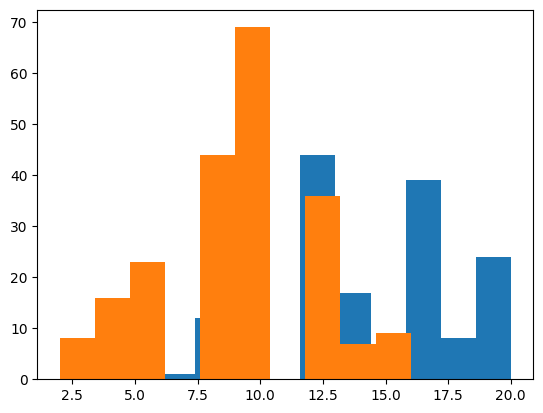

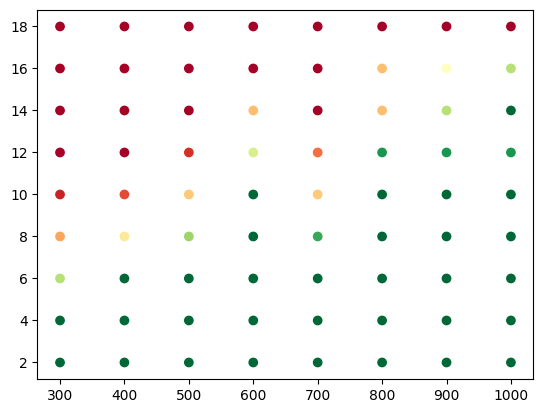

In [17]:
plt.hist(rr[rr[:,2]==0,1])
plt.hist(rr[rr[:,2]==1,1])
plt.figure()
plt.scatter(agg[:,0], agg[:,1], c=agg[:,2], cmap='RdYlGn')

In [11]:
np.save('parses.npy', rr)

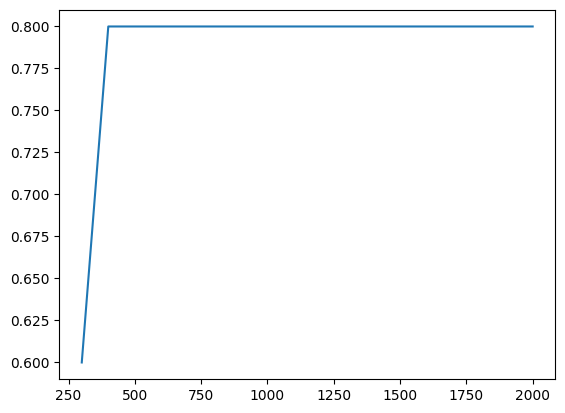

In [54]:
x = agg[agg[:,1]==6,]
x.sort(axis=0)
plt.plot(x[:,0], x[:,2])

In [40]:
x